# yolo转onnx并使用onnxruntime推理(ipynb)

在此笔记本中，会较为详细的解析如何将Yolo模型转换为Onnx模型并使用onnxruntime进行推理

以及使用cv2等包进行预处理和后处理

## 前置操作

首先需要判断是否使用GPU，如果需要使用请先运行下方命令查看CUDA版本

In [1]:
!nvidia-smi

Tue Mar 11 11:33:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:3B:00.0 Off |                    0 |
| N/A   81C    P0             88W /  300W |    2034MiB /  32768MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

在转换模型并使用onnx推理之前需要先安装需要的软件包

如果需要使用CUDA，请先运行上方的命令并获取到`CUDA Version`，如是`11.8`那么就将后面的`extra-index-url`中的`cu124`更改为`cu118`

如果是使用CPU，请将`onnxruntime-gpu`更改为`onnxruntime`，并将`extra-index-url`中的`cu124`更改为`cpu`

### 虚拟环境创建

**⚠️注意！**

在接下来的操作运行之前，推荐最好保证自己处在虚拟环境中，防止包版本冲突而无法使用等问题

如果您不知道如何创建虚拟环境，可以运行下方的命令直接创建一个`venv`名字的虚拟环境在`.venv`文件夹中

(因篇幅有限，在此不考虑使用conda等环境)

In [2]:
!python -m .venv venv

/home/quwei/anaconda3/envs/jupyterlab/bin/python: Relative module names not supported


如是Windows系统则使用powershell运行下方的命令(如果是cmd则将`Activate.ps1`替换为`activate.bat`)

In [ ]:
!./.venv/Scripts/Activate.ps1

如果是linux系统，请检查`./venv/bin`中是否有`activate`文件，

如果有，则使用`soucre ./venv/bin/activate`

如果无，则之后在运行`python`/`pip`时需在前添加`./venv/bin/`进行运行

### 安装依赖包

In [2]:
!pip install torch torchvision ultralytics onnxruntime-gpu onnxslim --extra-index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124


在安装完成之后，可以运行下方代码块测试安装情况

In [3]:
# 检查 Pytorch
import torch
import torchvision
print('Pytorch 版本：', torch.__version__)
print('CUDA 是否可用：',torch.cuda.is_available())

Pytorch 版本： 2.4.1+cu118
CUDA 是否可用： True


如果输出情况是对应着安装信息就表示安装成功，可以继续进行下一步操作啦

## Yolo转onnx模型

在开始正式转换模型前，请先将模型路径设置正确

In [4]:
model_path = './model/best_1.pt'

对于yolo模型来说，官方已经提供了转换方法，可以直接转换

In [5]:
from ultralytics import YOLO
model = YOLO(model_path)
model.export(format="onnx")

Ultralytics 8.3.86 🚀 Python-3.8.20 torch-2.4.1+cu118 CPU (Intel Xeon Gold 6271C 2.60GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'model/best_1.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 1.2s, saved as 'model/best_1.onnx' (10.1 MB)

Export complete (1.5s)
Results saved to /home/quwei/nar_projects/jupyter/yolo-onnx/model
Predict:         yolo predict task=detect model=model/best_1.onnx imgsz=640  
Validate:        yolo val task=detect model=model/best_1.onnx imgsz=640 data=./datasets/data.yaml  
Visualize:       https://netron.app


'model/best_1.onnx'

其中，在导出模型时可以附带导出参数，参数设置可以查看下方的表格

| 论据        | 类型              | 默认值          | 说明                                                         |
| :---------- | :---------------- | :-------------- | :----------------------------------------------------------- |
| `format`    | `str`             | `'torchscript'` | 导出模型的目标格式，例如 `'onnx'`, `'torchscript'`, `'tensorflow'`或其他，定义与各种部署环境的兼容性。 |
| `imgsz`     | `int` 或 `tuple`  | `640`           | 模型输入所需的图像尺寸。对于正方形图像，可以是一个整数，或者是一个元组 `(height, width)` 了解具体尺寸。 |
| `keras`     | `bool`            | `False`         | 可导出为 Keras 格式 [TensorFlow](https://www.ultralytics.com/glossary/tensorflow)SavedModel的 Keras 格式，提供与TensorFlow serving 和 API 的兼容性。 |
| `optimize`  | `bool`            | `False`         | 在导出到TorchScript 时，应用针对移动设备的优化，可能会减小模型大小并提高性能。 |
| `half`      | `bool`            | `False`         | 启用 FP16（半精度）量化，在支持的硬件上减小模型大小并可能加快推理速度。 |
| `int8`      | `bool`            | `False`         | 激活 INT8 量化，进一步压缩模型并加快推理速度，同时将[精度](https://www.ultralytics.com/glossary/accuracy)损失降至最低，主要用于边缘设备。 |
| `dynamic`   | `bool`            | `False`         | 允许为ONNX 、TensorRT 和OpenVINO 导出动态输入尺寸，提高了处理不同图像尺寸的灵活性。 |
| `simplify`  | `bool`            | `True`          | 简化了ONNX 输出的模型图。 `onnxslim`这可能会提高性能和兼容性。 |
| `opset`     | `int`             | `None`          | 指定ONNX opset 版本，以便与不同的ONNX 解析器和运行时兼容。如果未设置，则使用最新的支持版本。 |
| `workspace` | `float` 或 `None` | `None`          | 为TensorRT 优化设置最大工作区大小（GiB），以平衡内存使用和性能；使用 `None` TensorRT 进行自动分配，最高可达设备最大值。 |
| `nms`       | `bool`            | `False`         | 在支持的情况下，为导出模型添加非最大值抑制 (NMS)（请参阅导出格式），提高检测后处理效率。 |
| `batch`     | `int`             | `1`             | 指定导出模型的批量推理大小，或导出模型将同时处理的图像的最大数量。 `predict` 模式。 |
| `device`    | `str`             | `None`          | 指定导出设备：GPU (`device=0`）、CPU (`device=cpu`)、MPS for Apple silicon (`device=mps`）或NVIDIA Jetson 的 DLA (`device=dla:0` 或 `device=dla:1`). |
| `data`      | `str`             | `'coco8.yaml'`  | 通往 [数据集](https://docs.ultralytics.com/zh/datasets) 配置文件（默认： `coco8.yaml`)，对量化至关重要。 |

在导出完成之后，您可以在[netron](https://netron.app)中查看模型流程图以及基本信息

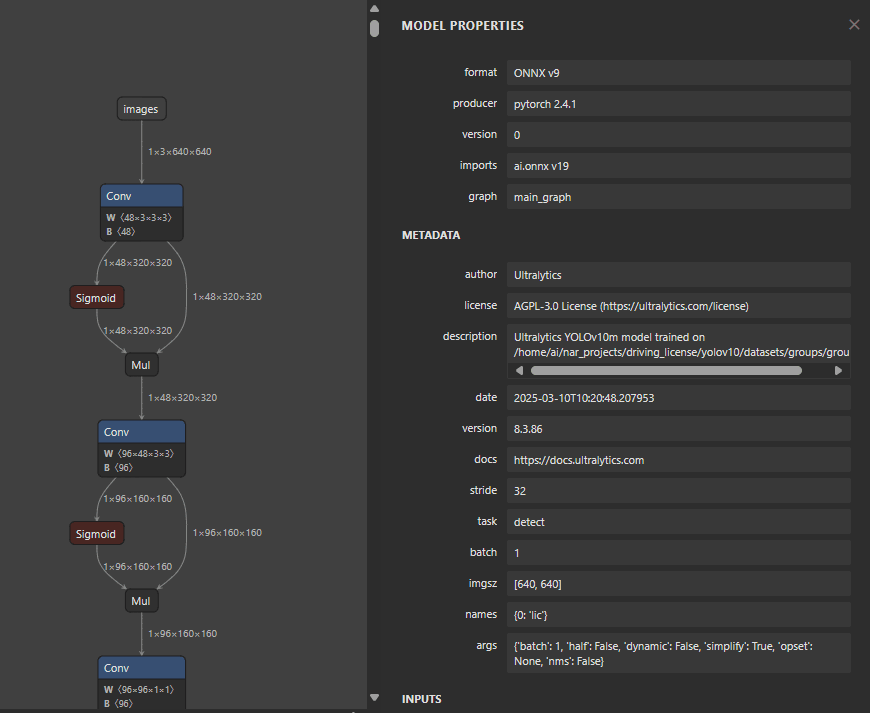

## 使用onnxruntime进行推理

### 导入需要的包

In [6]:
import numpy as np
import onnxruntime as ort
import cv2

# 非必要
import matplotlib.pyplot as plt
from PIL import Image

### 预处理+后处理函数

In [7]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def preprocess_image(image, target_size):
    height, width, _ = image.shape
    length = max(height, width)
    padded_image = np.zeros((length, length, 3), np.uint8)
    padded_image[:height, :width] = image
    scale = length / target_size[0]

    blob = cv2.dnn.blobFromImage(padded_image, scalefactor=1 / 255, size=target_size, swapRB=True)
    return blob, scale

def postprocess_image(outputs, scale, original_image):
    # 对于Yolov8/Yolov11需要transpose转换
    outputs = np.array([cv2.transpose(outputs[0])])
    rows = outputs.shape[1]

    boxes, scores, class_ids = [], [], []
    for i in range(rows):
        classes_scores = outputs[0][i][4:]
        _, maxScore, _, maxClassIndex = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.25:
            box = [
                outputs[0][i][0] - (0.5 * outputs[0][i][2]),
                outputs[0][i][1] - (0.5 * outputs[0][i][3]),
                outputs[0][i][2],
                outputs[0][i][3],
            ]
            boxes.append(box)
            scores.append(maxScore)
            class_ids.append(int(maxClassIndex[0]))

    # nms
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)
    detections = []
    # 组合结果并绘出识别框
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            "class_id": class_ids[index],
            "class_name": CLASSES.get(class_ids[index], "Unknown"),
            "confidence": scores[index],
            "box": box,
            "scale": scale,
        }
        detections.append(detection)
        draw_bounding_box(
            original_image,
            class_ids[index],
            scores[index],
            round(box[0] * scale),
            round(box[1] * scale),
            round((box[0] + box[2]) * scale),
            round((box[1] + box[3]) * scale),
        )

    cv2.imwrite("output.jpg", original_image)
    return detections

### 设置模型路径、测试图片路径以及标签列表

In [12]:
# 模型
onnx_model = "./model/best_1.onnx"
# 测试图片
input_image = "2.png"
# 标签列表，以{0:'...',1:'...'}编写
CLASSES = {0: 'car'}
# 是否使用GPU
use_gpu = True
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))

### 获取到cuda状态并创建推理会话

In [13]:
if use_gpu:
    providers = ["CUDAExecutionProvider"]
else:
    providers = ["CPUExecutionProvider"]
session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
# 创建推理会话
session = ort.InferenceSession(onnx_model, session_options=session_options, providers=providers)

2025-03-11 11:35:03.011408933 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory



### 获取模型接收大小

In [14]:
model_inputs = session.get_inputs()
input_shape = model_inputs[0].shape
input_size = input_shape[2],input_shape[3]
print(input_shape)

[1, 3, 640, 640]


### 开始进行推理

In [15]:
# 读取
original_image = cv2.imread(input_image)
# 预处理
blob, scale = preprocess_image(original_image,input_size)
# 推理
outputs = session.run(None, {model_inputs[0].name: blob})[0]
# 后处理
detections = postprocess_image(outputs, scale, original_image)

### 输出结果

[{'class_id': 0, 'class_name': 'car', 'confidence': 0.5472288727760315, 'box': [482.88812255859375, 108.10301971435547, 161.7395, 107.87044], 'scale': 2.01875}]


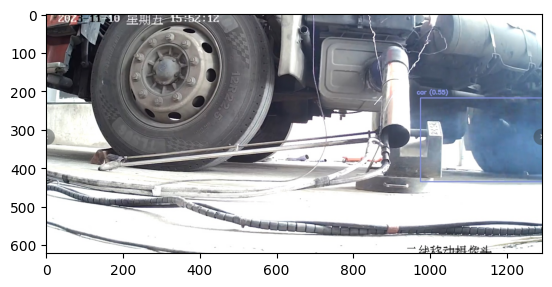

In [16]:
print(detections)
img=Image.open("./output.jpg")
plt.imshow(img)
plt.show()